# [Book Reading Chapter7 Part2]

> [7.4 GooLeNet]

> [7.5 BatchNormalization]

> [7.6 ResNet]

> [7.7 DenseNet]


## Setting

### 1) Import Modules

In [ ]:
# PyTorch Modeling
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# Data Loading
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# Reproducibility
import random
import numpy as np

# Draw plot
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

# Others
import sys

### 2) Set Seed for reproducibility
https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# torch.use_deterministic_algorithms(True)

### 3) Download Data
https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py

In [ ]:
def load_data_fashion_mnist(batch_size, image_size) -> dict :
    """
    Dive Into Deeplearning Github에 공개된 데이터 다운로드 코드를 변형
    Fashion MNIST 데이터를 './data' 경로에 다운로드하여 DataLoader로 반환 
    """ 
    trans = transforms.Compose([transforms.Resize(image_size),                  # 이미지를 96으로 Resize 후
                                transforms.ToTensor()])                         # Tensor로 바꿔주기 위한 세팅

    mnist_train = torchvision.datasets.FashionMNIST(                            # TorchVision에 있는 Fashion MNIST 데이터 로딩
        root="./data", train=True, transform=trans, download=True)              # ../data에 Transform을 적용한 채 Train 데이터 다운
    
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)             # ../data에 Transform을 적용한 채 Test  데이터 다운
    
    return {
            'train' : DataLoader(mnist_train, batch_size, shuffle=True),        # DataLoader 형태로 반환 (Train은 Shuffle O)
            'test'  : DataLoader(mnist_test, batch_size, shuffle=False)         # DataLoader 형태로 반환 (Test는  Shuffle X)
            }

### 4) Default Variables for Training

In [ ]:
# Dataloaders
dataloaders = load_data_fashion_mnist(256, 96) # Batch_size, image_size
dataloaders2 = load_data_fashion_mnist(256, 28) # for LeNet + Batch Normalization

# Device Setting
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### 4) Code for Training Model

In [ ]:
def Chapter7_Training(
                      model, 
                      dataloaders,
                      criterion,
                      optimizer,
                      num_epochs : int
                      ) -> None : 
    
    train_accuracy = 0                                                          # Train Accuracy
    train_loss = 0                                                              # Train Loss
    train_losses = []                                                           # Logging Train Losses
    test_accuracy = 0                                                           # Test Accuracy
    test_loss = 0                                                               # Test Loss
    test_losses = []                                                            # Logging Test  Losses


    for num_epoch in range(num_epochs) :                                        # 주어진 Epoch 동안
        for phase in ['train', 'test'] :                                        # Train phase인지, Test phase인지를 판단하여
            if phase == 'train' :                                               # Train phase이면
                model.train()                                                   # model.train()으로 전환 => Batch Normalization 등의 상태를 전환
            else :                                                              # Test  phase이면
                model.eval()                                                    # model.eval()로 전환
            
            running_accuracy = 0                                                # Epoch에서의 Accuracy를 계산하기 위한 변수
            running_loss = 0                                                    # Epoch에서의 Loss를 계산하기 위한 변수
            
            for X, y in dataloaders.get(phase) :                                # dataloaders에서 phase에 맞게 dataloader를 가져오고, 이를 이용하여 X와 y를 batch 단위로 추출
                X = X.to(device)                                                # X를 주어진 device에 올림
                y = y.to(device)                                                # y를 주어진 device에 올림
                optimizer.zero_grad()                                           # 모델의 매개변수의 변화도를 0으로 만듦 -> optimizer는 누적되는 특성이 있어 적용해줘야 함

                with torch.set_grad_enabled(phase == 'train') :                 # Gradient 계산 여부 (계산하지 않으면 속도의 향상이 있으므로, validation과 test를 검증할 때는 적용하는 것이 좋다)
                    output = model(X)                                           # model의 결과
                    loss = criterion(output, y)                                 # loss function (ex : CrossEntropyLoss)를 이용하여 loss 계산

                    if phase == 'train':                                        # train phase일 경우,
                        loss.backward()                                         # 역전파 : 모델의 매개변수의 loss의 변화 계산
                        optimizer.step()                                        # 매개변수 갱신

                running_accuracy += (output.argmax(1)==y).sum().item()          # 확률 값이 제일 큰 값과 실제 값이 같은 수를 더해줌
                running_loss += loss.item()                                     # loss를 더해줌
                

            epoch_accuracy = running_accuracy / len(dataloaders.get(phase).dataset) # Epoch가 끝나면, dataset의 크기로 나누어, Accuracy 계산 (맞춘 개수 / 전체 개수)
            epoch_loss = running_loss / len(dataloaders.get(phase).dataset)     # Epoch가 끝나면, 평균 Loss를 계산


            if phase == 'train' :                                               # Train Phase이면,
                train_accuracy = epoch_accuracy * 100                           # Train Accuracy 갱신
                train_loss = epoch_loss                                         # Train Loss 갱신
                train_losses.append(train_loss)                                 # Train Loss 기록

            else :                                                              # Test Phase이면
                test_accuracy =  epoch_accuracy * 100                           # Test Accuracy 갱신
                test_loss = epoch_loss                                          # Test Loss 갱신
                test_losses.append(test_loss)                                   # Test Loss 기록

            pl.plot(train_losses, c = 'r', marker = 'o')                        # Train Loss는 Red 선으로 그리며, Loss의 좌표에는 'o' 마커로 표시
            pl.plot(test_losses, c= 'b', marker = 'o')                          # Test  Loss는 Blue선으로 그리며, Loss의 좌표에는 'o' 마커로 표시
            display.clear_output(wait=True)                                     # display 되어있는 Output을 지움
            display.display(pl.gcf())                                           # plot을 지움

            sys.stdout.write("\r[EPOCH %d/%d] [Train Loss : %f] [Train Accuracy : %f] [Test  Loss : %f] [Test  Accuracy : %f]"
                  % (
                      num_epoch + 1,
                      num_epochs,
                      train_loss,
                      train_accuracy,
                      test_loss,
                      test_accuracy                                             # sys.stdout.write를 활용하여 같은 위치에 숫자만 변경하며 출력
                    )
                  )

    return model


### 5) Weight Initialization

In [ ]:
def initialize_weights(model):
    # track all layers
    for m in model.modules():                                                   # 모델의 모듈들에 대하여

        if isinstance(m, nn.Conv2d):                                            # Conv2d이면 
            nn.init.xavier_normal_(m.weight)                                    # 모델의 weight는 Xaiver Initialization
            if m.bias is not None:                                              # 모델의 bias는 
                nn.init.constant_(m.bias, 0)                                    # 0으로 고정

        elif isinstance(m, nn.BatchNorm2d):                                     # BatchNormlization이면
            nn.init.constant_(m.weight, 1)                                      # weight는 1    
            nn.init.constant_(m.bias, 0)                                        # bias는 0으로 고정

        elif isinstance(m, nn.Linear):                                          # Linear 모델이면
            nn.init.xavier_normal_(m.weight)                                    # 모델의 weight는 Xaiver Intialization
            nn.init.constant_(m.bias, 0)                                        # 모델의 bias는 0으로 고정
    return model

# 7.4 GoogLeNet (2014.09 on arxiv)

### 1) Introduction

- 2014 ImageNet Challenge Winner
- Combined NiN + More Repeated Blocks
> 1.Inception Blocks<br>2.Deeper Architecture

### 2) Inception Blocks
<img src='https://raw.githubusercontent.com/JayHong99/2022_Summer_BookReading/master/Chapter7/Images/Inception_Block.png?raw=true' width='600'>

- Inception "We need to go deeper"에서 차용
- 4가지 평행 구조의 Layer
> (1x1 Conv)<br>(1x1 Conv) -> (3x3 Conv, pad1)<br> (1x1 Conv) -> (5x5 Conv, pad2)<br> (3x3 MaxPool, pad 1) -> (1x1 Conv)

특징
- 1x1 Conv 사용 -> Channel의 수 감소 (= 모델 복잡도 감소)
- 다양한 Filter Size -> 이미지를 다양하게 탐색
- 이미지의 크기는 input과 output 동일

### 3) Deeper Architecture

![GooLeNet Architecture](https://d2l.ai/_images/inception-full.svg)

- 이전 모델인 NiN은 4개의 Block을 사용
- VGG11도 5개의 Block 사용
- GooLeNet은 총 9개의 Inception Block 사용

결과적으로, 계산의 비용이 증가하고, 변형이 쉽지 않음

### 4) Implement with PyTorch

**<Inception Block 구현>**

In [ ]:
class Inception(nn.Module) : 
    """
    c1, c2, c3, c4는 개별 path에서 Output Channel의 수 이다.
    """
    def __init__(self, in_channels, c1 : int, c2 : list, c3 : int, c4 : int, **kwargs) -> None: 
        super(Inception, self).__init__(**kwargs)
        """ 1번 경로 """
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size = 1)

        """ 2번 경로 """
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size = 1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size = 3, padding = 1)

        """ 3번 경로 """
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size = 1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size = 5, padding = 2)

        """ 4번 경로 """
        self.p4_1 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size = 1)

    def forward(self, x : torch.FloatTensor) -> torch.Tensor :
        p1 = F.relu(self.p1_1(x))                     # 1x1 Conv
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))  # 1x1 Conv -> ReLU -> 3x3 Conv -> ReLU
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))  # 1x1 Conv -> ReLU -> 3x3 Conv -> ReLU
        p4 = F.relu(self.p4_2(self.p4_1(x)))          # 3x3 MaxPool -> 1x1 Conv
        return torch.cat((p1, p2, p3, p4), dim = 1)   # 이미지의 크기는 모두 동일하니, channel의 방향으로 Concatenate

**<GooLeNet 구현>**

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),  # Kernel 7 with Stride 2 and padding 3 => 이미지 사이즈 절반 (64, 48,48)
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size =  3, stride = 2, padding = 1))     # Kernel 3 with Stride 2 and Padding 1 => 이미지 사이즈 절반 (64, 24,24)


b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size = 1),                          # 1x1 Conv => (64, 24, 24)
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size = 3, padding = 1),            # Kernel 3 with Padding 1 => 이미지 사이즈 동일 (192, 24,24)
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))      # Kernel 3 with Stride 2 and Padding 1 => 이미지 사이즈 절반 (192, 24,24)


b3 = nn.Sequential(Inception(192, 64, (96, 128), (16,32), 32),                  # Inception Block (192 => 64 + 128 + 32 + 32 = 256) => 이미지 사이즈 동일 (256, 12, 12)
                   Inception(256, 128, (128,192), (32, 96), 64),                # Inception Block (256 => 128 + 192 + 96 + 64 = 480) => 이미지 사이즈 동일 (480, 12, 12)
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))      # Kernel 3 with Stride 2 and Padding 1 => 이미지 사이즈 절반 (480, 6, 6)


b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),                # Inception Block (480 => 192 + 208 + 48 + 64 = 512) => 이미지 사이즈 동일 (512, 48, 48)
                   Inception(512, 160, (112, 224), (24, 64), 64),               # Inception Block (512 => 160 + 224 + 64 + 64 = 512) => 이미지 사이즈 동일 (512, 6, 6)
                   Inception(512, 128, (128, 256), (24, 64), 64),               # Inception Block (512 => 128 + 256 + 64 + 64 = 256) => 이미지 사이즈 동일 (512, 6, 6)
                   Inception(512, 112, (144, 288), (32, 64), 64),               # Inception Block (512 => 112 + 288 + 64 + 64 = 528) => 이미지 사이즈 동일 (528, 6, 6)
                   Inception(528, 256, (160, 320), (32, 128), 128),             # Inception Block (528 => 256 + 320 + 128 + 128 = 256) => 이미지 사이즈 동일 (832, 6, 6)
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))            # Kernel 3 with Stride 2 and Padding 1 => 이미지 사이즈 절반 (832, 3, 3)


b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),             # Inception Block (832 => 256 + 320 + 128 + 128 = 832) => 이미지 사이즈 동일 (832, 3, 3)
                   Inception(832, 384, (192, 384), (48, 128), 128),             # Inception Block (832 => 384 + 384 + 128 + 128 = 1024) => 이미지 사이즈 동일 (1024, 3, 3)
                   nn.AdaptiveAvgPool2d((1,1)),                                 # Adaptive AvgPool2d는 Image의 Output을 자동으로 맞추어 Pooling하는 Layer => (1024,1,1)
                   nn.Flatten())                                                # Flatten => (1024)

GooLeNet = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))               # FC는 단층으로, output = 10

**<맞게 구축했는지 파악>**

In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in GooLeNet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


### 5) Training with PyTorch

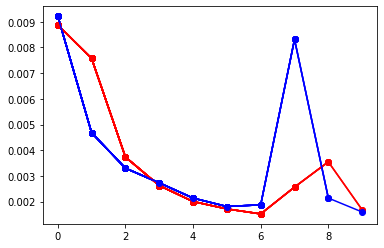

[EPOCH 10/10] [Train Loss : 0.001678] [Train Accuracy : 84.095000] [Test  Loss : 0.001594] [Test  Accuracy : 84.980000]

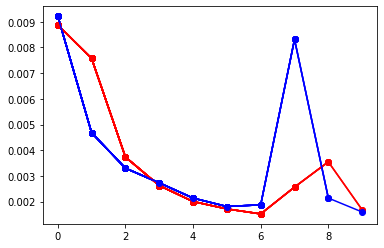

In [ ]:
model = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10)).to(device)
model = initialize_weights(model)

num_epochs = 10
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model = Chapter7_Training(model, dataloaders, criterion, optimizer, num_epochs)

# 7.5 BatchNormalization

## 1) 내용 소개

#### (1) 필요성


i) 최종 결과에 차이가 크다
> Chapter 4에서 집 값 예측할 때 제일 먼저 했던 일이 Standard Scailing<br>평균과 std로 값을 나누어주었음

ii) Internal Distribution drift
> 내부 Layer의 Output들의 범위가 다양함<br>BatchNorm 저자들은 이 drift가 network의 수렴을 막는다고 가정

> Internal Covariant Shift

<img src='https://write365project.files.wordpress.com/2018/01/18671050_10155018408854584_5877734482386509886_n-1.jpg?w=629' width='300px'>

>> activation(WX+b) 를 여러번 거치면, 내부 데이터의 분포가 변화<br>학습 속도의 저하, Learning Rate, Weight Initialization의 영향을 많이 받음<br>가중치 학습 불가의 상태(ex : 반복된 sigmoid로 인한 Vanishing Gradient



iii) 과적합 방지
> 모델이 복잡할 수록, Regularization은 더 중요








#### (2) 수식
- 주어진 Minibatch에서 Mean & Std를 계산하여 Normalize
- 단, BatchSize가 1일때는 유의
- Batch Size가 충분히 클 때 효과적이고, 안정적

$$ \mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}. $$

$$ \mu_B : Mean$$
$$ \hat{\sigma}_B : Std$$
$$ \gamma : scale\space parameter$$
$$ \beta : shift\space parameter $$ 

> gamma와 beta도 학습하는 파라미터
>> 교재에는 적혀있지 않지만, gamma와 beta를 이용하여 원래의 모델이 표현하고자 한 것을 살려냄<br> ex) sigmoid는 -1.96~1.96 사이에서는 선형성을 나타냄 => Distribution Shift를 활용하여 비선형성으로 바꾸어준다

---
비선형성의 필요성?

<img src = 'https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/spiral.1-2.2-2-2-2-2-2.gif' width='300px'>

https://github.com/JayHong99/Papers/tree/origin/Deep%20Learning%20Basic/2021.12.29%20Batch%20Normalization

#### (3) 특징
- 50~100 정도의 Batch Size가 가장 효과적
- 학습할 때 마다 매번 결과가 달라질 수 있음 (시작 Batch와 끝 Batch도 달라질 수 있음)
- 다만, 학습하며 전체 데이터의 mean, std를 moving average를 이용하여 저장하기에, Inference는 고정

#### (4) 적용
Fully Connected Layer

$$ \mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ). $$

BatchNormalize(Weight * X + bias) 이후 Activation Function 적용
> Output에 대하여 BN을 적용하고, Activation 적용

Convolutional Layers

- Minibatch : m
- height : p
- width : q

각 Channel마다 m x p x q개의 평균과 분산을 구하여 적용

---

Activation과 BatchNorm 순서의 반대의견
> Activation 이후에 Batch Normalize를 해줘야 한다.<br>원하는 부분을 정확히 표현 후, 정제하는 것이 좋을 것이다.

논쟁
> 논문의 저자는 교재의 방법을 제안했으나, 실제로는 반대의견이 성능이 좋은 경우도 많음<br>따라서 여러 경우를 테스트 해보는 것을 추천...

https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md


#### (5) 반대 의견

Batch Normalization은 optimization landscape를 더 좋게 만들 것으로 생각됨

<img src='http://www.offconvex.org/assets/optimization-beyond-landscape-points.png' width = '300px'>


> 하지만 이건 주장이지, 증명이 되지 않았으며, weight decay만으로도 충분히 좋다.


Internal Covriant Shift
> 학습하는 중간에, 데이터의 분포가 달라진다고 가정
>> 비판 1 : 사실 Covariant Shift와는 무관하다<br>비판 2 : 왜 Batch Normalization이 Internal Covariant Shift를 막아주는지에 대한 증명이 안되었다.

그럼에도, NIPs Test of Time Award 수상, 계속해서 연구되는 주제 등으로 성공적인 결과

---
이후 Batch Normalization의 한계를 지적하며 Google에서 Layer Normalization 발표

Batch Norm은 RNN에서 부적합
> Batch Norm은 Time-Step마다 batch 단위로 계산하고 적용해야 하지만, 만약 Test의 길이가 Train보다 길다면 적용이 불가능하다.

Layer 단위로 Normalization을 적용하여, 새로운 데이터에도 크게 변하지 않고 적용 가능한 불변성을 지니게 하면, 파라미터의 변동성이 낮아 빠른 학습이 가능

## 2) 코드

#### (1) Batch Norm

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():                                             # TEST 상태이면,
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)                # Moving AVG, VAR을 이용하여 Normalize
    else:                                                                       # Train 상태라면,
        assert len(X.shape) in (2, 4)                                           # 2차원 Or 4차원 Input만 구현                                           
        if len(X.shape) == 2:                                                   # 2차원 (FC)이면
            mean = X.mean(dim=0)                                                # Batch에 대한 평균
            var = ((X - mean) ** 2).mean(dim=0)                                 # Batch에 대한 분산
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)                          # Channel을 제외한 나머지를 이용하여 모든 평균 계산
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)           # Channel을 제외한 나머지를 이용하여 모든 분산 계산
        X_hat = (X - mean) / torch.sqrt(var + eps)                              # Normalize

        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean          # Moving Mean 업데이트
        moving_var = momentum * moving_var + (1.0 - momentum) * var             # Mvoing Var 업데이트
    Y = gamma * X_hat + beta                                                    # Layer의 Output은 gamma와 beta를 곱하고 더하여 반환
    return Y, moving_mean.data, moving_var.data

#### (2) Class로 구현

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

#### (3) LeNet에 적용하여 학습

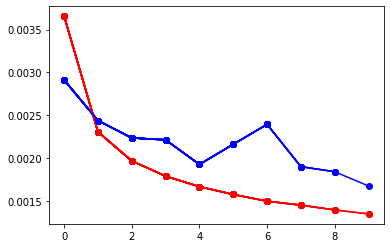

[EPOCH 10/10] [Train Loss : 0.001347] [Train Accuracy : 87.911667] [Test  Loss : 0.001673] [Test  Accuracy : 85.010000]

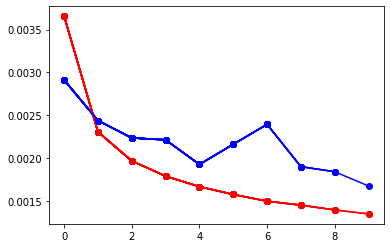

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)).to(device)

model = initialize_weights(model)

num_epochs = 10
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model = Chapter7_Training(model, dataloaders2, criterion, optimizer, num_epochs)

#### (4) Pytorch 내장 모듈로 활용

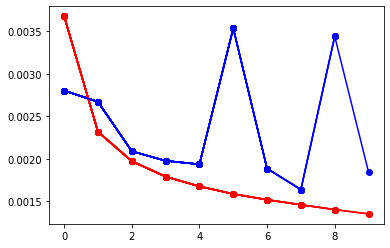

[EPOCH 10/10] [Train Loss : 0.001352] [Train Accuracy : 87.885000] [Test  Loss : 0.001845] [Test  Accuracy : 83.400000]

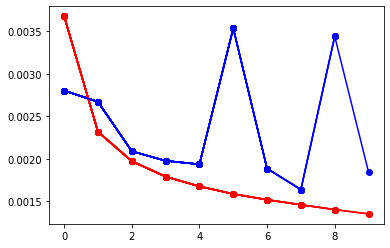

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)).to(device)


model = initialize_weights(model)

num_epochs = 10
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model = Chapter7_Training(model, dataloaders2, criterion, optimizer, num_epochs)

# 7.6 ResNet (2015.12 on Arxiv)
2015 ILSVR Winner

## 1) 함수 Class

<img src = 'https://d2l.ai/_images/functionclasses.svg' width = '800px'>


$$ f^*_\mathcal{F} \stackrel{\mathrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}. $$

학습의 목적 : Weight와 Bias가 포함된 함수 f를 수정하여, loss를 최소화

f를 포함하는 함수 F보다 더 효과적이고 강력한 F'이 있다고 하자.

왼쪽의 이미지 :  f1을 포함하는 F1보다 더 나은 F2가 F1을 포함한다는 보장이 없음

오른쪽의 이미지 : f1을 포함하는 F1보다 더 나은 F2는 F1을 포함

따라서 딥러닝에서는, 새로 추가하는 Layer가 f(x) = x를 만족한다면, 새로운 모델이 기존 모델보다 좋거나 같을 것이다.


## 2) Residual Blocks
<img src = 'https://d2l.ai/_images/residual-block.svg' width = '500px'>

Residual Block은, f(x) - x = 0이 될 가능성을 열어둠

만약 f(x) = x라면, Identity Mapping이 됨
> 모델은 f(x) - x를 학습<br>실제로 Identity Matrix라면, weight와 bias를 위의 layer로 weight를 전달할 수 있음<br>즉, 해당 layer에서는 학습하지 않아도 괜찮음


Residual Connection

> x를 residual block의 output에 add하여 보내줌

---
Residual Block이 효과적인 이유
> 모델이 깊어지면 Exploding Gradient나 Vanishing Gradient가 발생합니다..<br>기존의 구조는 이전 Layer의 학습된 파라미터를 받아 다음 Layer에 전달해야 합니다<br>이 경우, 이전 Layer에서 학습한 효과적인 파라미터가 사라질 수 있습니다.<br>반면 Residual Connection은 강제로 업데이트해야하는 상황을 막아 효과적인 Gradient를 유지하게 만들어줍니다

## 3) Residual Block 변형

<img src = 'https://d2l.ai/_images/resnet-block.svg' width = '500px'>

Residual Connection에 전달할 때 1x1 Conv Layer를 통과
> Channel의 크기 조정<br>1x1 Conv Layer는 MLP와 동일한 효과가 있으나, 적은 파라미터, Non-Linearity, 채널 수 변경이 가능<br>따라서, Residual Block 내부에서 Channel의 수를 줄여도 1x1 Conv를 이용하여 output size를 맞춰줄 수 있음

## 4) ResNet

<img src = 'https://d2l.ai/_images/resnet18.svg' height = '600px'>


## 5) 구현

Residual Block

In [ ]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,                    # Conv2d(in, out, 3, 1, stride)
                               kernel_size=3, padding=1, stride=strides)        # Conv2d(in, out, 3, 1)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,                # 1x1 Conv2d(in, out, 1, stride)
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)               
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))                                     # Conv1 -> Batch Norm -> ReLU
        Y = self.bn2(self.conv2(Y))                                             # Conv2 -> Batch Norm
        if self.conv3:                                                          # if true) Conv2 -> Conv3
            X = self.conv3(X)
        Y += X                                                                  # Residual Connection
        return F.relu(Y)

ResNet Block

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

ResNet18

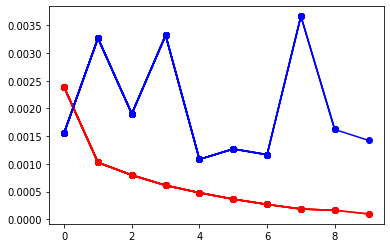

[EPOCH 10/10] [Train Loss : 0.000095] [Train Accuracy : 99.200000] [Test  Loss : 0.001424] [Test  Accuracy : 91.690000]

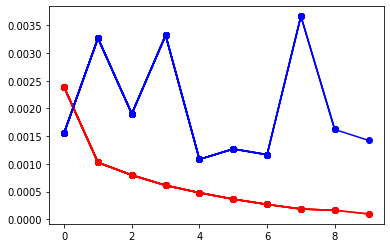

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

model = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10)).to(device)

model = initialize_weights(model)

num_epochs = 10
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model = Chapter7_Training(model, dataloaders, criterion, optimizer, num_epochs)

# 7.7 DenseNet (2016.08 on Arxiv)

## 1) ResNet to DenseNet

테일러 급수
$$ f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

ResNet의 관점에서 해석 : f(x) = x + g(x)

> x와 g(x) 사이의 관계도 반영할 수 없을까?

<img src = 'https://d2l.ai/_images/densenet-block.svg' width = '500px'>

> Residual Block에서는 Add를 해주었다면, DenseNet은 Concatenate 활용
<img src = 'https://d2l.ai/_images/densenet.svg' width = '500px'>

## 3) Transition Layers

계속해서 Concatenate하면, Channel의 수가 너무 커진다.
> 1x1 Conv Layer를 이용하여 Channel의 수를 줄여주자.

이미지의 크기를 줄여주기 위한 방법
> AveragePooling(kernel_size = 2, stride = 2) => 이미지 크기를 1/4으로 줄임

## 2) 구현

Convolutional Block

In [ ]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

Dense Block

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()                                      # 
        layer = []
        for i in range(num_convs):                                              # Block 01 : num_convs = 4, num_channels = 32, input_channels = 64
            layer.append(conv_block(                                            # NUM 1 : Conv2d(32 * 0 + 64, 64) -> concat([32, 64])
                num_channels * i + input_channels, num_channels))               # NUM 2 : Conv2d(32 * 1 + 64, 64) -> concat([96, 64])
        self.net = nn.Sequential(*layer)                                        # NUM 3 : Conv2d(32 * 2 + 64, 64) -> concat([128, 64])
                                                                                # NUM 4 : Conv2d(32 * 3 + 64, 64) -< concat([160, 64])
    def forward(self, X):                                                       
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)  
        return X                                                                # (224, 96, 96) (C,H,W)

Transition Block

In [ ]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

DenseNet

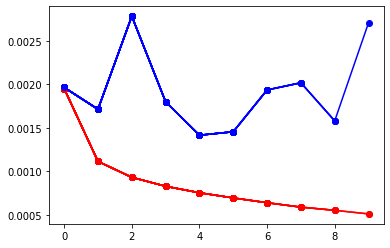

[EPOCH 10/10] [Train Loss : 0.000509] [Train Accuracy : 95.221667] [Test  Loss : 0.002707] [Test  Accuracy : 77.230000]

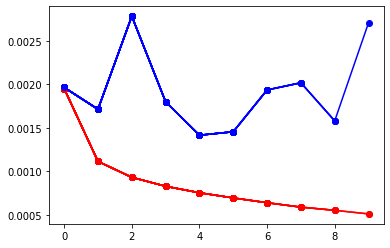

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),                       # 
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)).to(device)

num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))               
    num_channels += num_convs * growth_rate                                     # 64 + 96 =  160
    if i != len(num_convs_in_dense_blocks) - 1:                                 # 마지막 Layer가 아니라면,
        blks.append(transition_block(num_channels, num_channels // 2))          # Transition Block을 이용하여 Image의 사이즈와 Channel의 수를 줄인다.
        num_channels = num_channels // 2                                        # 채널의 수를 절반으로 감소
 

model = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)).to(device)


num_epochs = 10
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model = Chapter7_Training(model, dataloaders, criterion, optimizer, num_epochs)

In [ ]:
# pip install torchsummary
from torchsummary import summary

summary(model, input_size=(1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,